- The following codes are for the Kaggle test: Toxic Comment Classification Challenge.
- Description: "In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. You’ll be using a dataset of comments from Wikipedia’s talk page edits. 
- Dataset: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
- Approach: RNN/LSTM
- Result: Compared to using CNN approach, with fewer epochs and smaller embedding dimension, RNN with only 1 LSTM layer can achieve competitive loss and accuracy.

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [3]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [4]:
# Configuration
max_sequence_length = 100
max_vocab_size = 20000
embedding_dim = 50
validation_split = 0.2
batch_size = 128
epochs = 2

In [8]:
# prepare word embeddings
# glove
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % embedding_dim)) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype = 'float32')
        word2vec[word] = vec
print('number of word vectors: %s' % len(word2vec))

number of word vectors: 400000


In [9]:
# Prepare text samples and corresponding multi-headed labels
train = pd.read_csv("../large_files/toxic-comment/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[possible_labels].values

In [10]:
# convert sentences(strings) into integers
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences) # a list of lists where each sublist is word indexes

In [11]:
# word to idx mapping
word2idx = tokenizer.word_index

In [12]:
# pad sequences to get a NxT matrix, N = # of comments, T = length of each comment
data = pad_sequences(sequences, maxlen = max_sequence_length)
print("shape of data:", data.shape)

shape of data: (159571, 100)


In [14]:
# prepare embedding matrix
num_words = min(max_vocab_size, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word2idx.items():
    if i < max_vocab_size:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [16]:
# Create Embedding layer with pre-trained word embeddings
# Do not train embeddings with trainable = False 
embedding_layer = Embedding(
    input_dim = num_words,
    output_dim = embedding_dim,
    weights = [embedding_matrix],
    input_length = max_sequence_length,
    trainable = False
    )

In [17]:
# train LSTM network with a single LSTM layer
input_ = Input(shape = (max_sequence_length,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences = True)(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation = 'sigmoid')(x) # Use same feature matrix to calculate 6 separate sigmoid for 6 different labels

model = Model(input_, output)
# 6 different binary classification
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr = 0.01),
    metrics = ['accuracy']
    )

r = model.fit(
    data,
    targets,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split
    )

Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 104s 813us/step - loss: 0.0762 - acc: 0.9752 - val_loss: 0.0599 - val_acc: 0.9793
Epoch 2/2
127656/127656 [==============================] - 104s 816us/step - loss: 0.0573 - acc: 0.9800 - val_loss: 0.0576 - val_acc: 0.9800


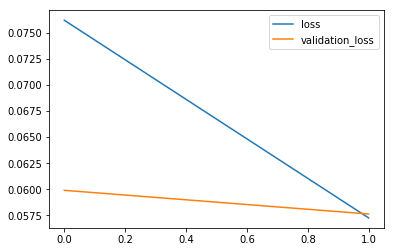

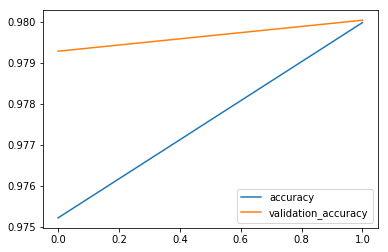

In [18]:
# plot the loss for training data and validation set
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

plt.plot(r.history['acc'], label = 'accuracy')
plt.plot(r.history['val_acc'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [19]:
# calcuate average auc across all 6 labels
p = model.predict(data)
aucs = []
for j in range(len(possible_labels)):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print("average auc across all labels: ",np.mean(aucs))

average auc across all labels:  0.9675546270191738
